In [71]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from scipy.stats import skew, kurtosis, linregress
import matplotlib.pyplot as plt

import seaborn as sns


In [110]:

# Load metadata
metadata = pd.read_csv('data/SPGC-metadata-2018-07-18.csv')

# Load KLD scores
kld_scores = pd.read_csv('data/KLDscores.csv')
extra_controls = pd.read_csv('data/extra_controls.csv')

data = pd.merge(metadata, kld_scores, left_on='id', right_on="filename", how='inner')

data = pd.merge(data, extra_controls, on='id', how='inner')
print(data.head())

indexes  = {}

def standard_deviation( kld_list):
  kld_array = np.array(eval(kld_list))
  return np.std(kld_array)

def avg_kld( kld_list):
  kld_array = np.array(eval(kld_list))
  return np.mean(kld_array)

def median_kld(kld_list):
  kld_array = np.array(eval(kld_list))
  return np.median(kld_array)

def total_positive_changes(kld_list):
  kld_array = np.diff(np.array(eval(kld_list)))
  positive_changes = kld_array[kld_array > 0]
  return np.sum(positive_changes)

def total_negative_changes(kld_list):
  kld_array = np.diff(np.array(eval(kld_list)))
  negative_changes = kld_array[kld_array < 0]
  return np.sum(negative_changes)

def coefficient_of_variation(kld_list):
  kld_array = np.array(eval(kld_list))
  mean = np.mean(kld_array)
  std = np.std(kld_array)
  return std / mean if mean != 0 else 0

def slope_of_trend( kld_list):
  kld_array = np.array(eval(kld_list))
  sections = np.arange(len(kld_array))
  slope, intercept, r_value, p_value, std_err = linregress(sections, kld_array)
  return slope

def calculate_iqr(kld_values):
    kld_array = np.array(eval(kld_values))
    q75, q25 = np.percentile(kld_array, [75, 25])
    iqr = q75 - q25
    return iqr

# Calculate Skewness
def calculate_skewness(kld_values):
    kld_array = np.array(eval(kld_values))
    return skew(kld_array)

# Calculate Kurtosis
def calculate_kurtosis(kld_values):
    kld_array = np.array(eval(kld_values))
    return kurtosis(kld_array)

# Calculate Slope, Intercept, and R-squared of KLD Trend
def calculate_slope_intercept(kld_values):
    kld_array = np.array(eval(kld_values))
    x = np.arange(len(kld_array))
    slope, intercept, r_value, p_value, std_err = linregress(x, kld_array)
    return intercept
def calculate_rsquare(kld_values):
    kld_array = np.array(eval(kld_values))
    x = np.arange(len(kld_array))
    slope, intercept, r_value, p_value, std_err = linregress(x, kld_array)
    return r_value**2


# Calculate First Derivative of KLD
def calculate_first_derivative(kld_values):
    kld_array = np.array(eval(kld_values))
    return np.diff(kld_array)[0]


def subject_score(row):
  score = 0
  weights = {
    "subj2_comedy": 4,
    "subj2_romance": 22,
    "subj2_thriller": 4,
    "subj2_western": 8,
    "subj2_horror": 23,
    "subj2_history": 12,
    "subj2_others": 12,
  }
  for key in weights.keys():
    score += weights[key] * row[indexes[key]]
  return score

def get_author_lived(row):
  birth = row[indexes["authoryearofbirth"]]
  death = row[indexes["authoryearofdeath"]]
  return (death - birth)
for i, key in enumerate(data):
  indexes[key] = i

def get_indexes():
  for i, key in enumerate(data):
    indexes[key] = i
  return indexes

lang_index = {"['en', 'myn']": 1, "['zh', 'en']": 2, "['en']": 3}
def is_multilang(val):
  l = eval(val)
  return 1 if len(l) > 1 else 0

author_lived = []
for d in data.values:
  author_lived.append(get_author_lived(d))
data["author_lived"] = author_lived

subjects = []
author_count = {}

for d in data.values:
  subjects.append(d[indexes["subjects"]])
  author_count[d[indexes["author"]]] = author_count.get(d[indexes["author"]], 0) + 1

yod_mul_numbook= []
for d in data.values:
  yod_mul_numbook.append(d[indexes["authoryearofdeath"]] / author_count[d[indexes["author"]]])
#print(len(set(subjects)))
#print(author_count)
data["yod_mul_numbook"] = yod_mul_numbook

def get_vowel_count(str):
  count = 0
      
  # Creating a set of vowels
  vowel = set("aeiouAEIOU")
    
  # Loop to traverse the alphabet
  # in the given string
  for alphabet in str:
    
      # If alphabet is present
      # in set vowel
      if alphabet in vowel:
          count = count + 1
  return count

def get_author_count(author):
  return author_count.get(author, 1)

def is_multiauth(author):
  return 1 if author_count.get(author, 1) > 1 else 0
def get_author_len(author):
  return (get_vowel_count(author) / len(author)) * get_author_count(author)
# Clean data

#print(data.isnull().sum())
#print(np.isinf(data).sum())


#data = data.replace([np.inf, -np.inf], np.nan).dropna()
data = data.dropna()


#kld_scores["kld_values"] = kld_scores["kld_values"].apply(eval)
#print(kld_scores)

def get_line_number(percent, total):
    return (percent * total) // 100

def get_partitioning(sentences):
  total = len(sentences)
  if len(sentences) == 1:
    return [sentences, sentences, sentences]
  
  if len(sentences) == 2:
    return [[sentences[0]], [sentences[1]], [sentences[1]]]
  if len(sentences) == 3:
    return [[sentences[0]], [sentences[1]], [sentences[2]]]
  if len(sentences) == 4:
    return [[sentences[0]], [sentences[1], sentences[2]], sentences[3]]
  else:
    intro_start, intro_end = 0, get_line_number(15, total)
    body_start, body_end = intro_end, get_line_number(80, total)
    conclusion_start, conclusion_end = body_end, total
    return [sentences[intro_start:intro_end], sentences[body_start:body_end], sentences[conclusion_start: conclusion_end]]

def diff_first_and_last_reveal(kld_list):
  kld_array = np.array(eval(kld_list))
  intro, body, last = get_partitioning(kld_array)
  #return abs(total_positive_changes(list(intro).__repr__()) - total_positive_changes(list(last).__repr__()))
  return abs(sum(intro) - sum(last))

def first_reveal_sum_abv_avg(kld_list):
  kld_array = eval(kld_list)
  intro, body, last = get_partitioning(kld_array)
  #return abs(total_positive_changes(list(intro).__repr__()) - total_positive_changes(list(last).__repr__()))
  return np.mean(kld_array)/sum(intro)
def last_reveal_sum_abv_avg(kld_list):
  kld_array = eval(kld_list)
  intro, body, last = get_partitioning(kld_array)
  #return abs(total_positive_changes(list(intro).__repr__()) - total_positive_changes(list(last).__repr__()))
  return np.mean(kld_array)/sum(last)
def body_reveal_sum_abv_avg(kld_list):
  kld_array = eval(kld_list)
  intro, body, last = get_partitioning(kld_array)
  #return abs(total_positive_changes(list(intro).__repr__()) - total_positive_changes(list(last).__repr__()))
  return np.mean(kld_array)/sum(body)

def kurt_structure(kld_list):
  kld_array = np.array(eval(kld_list))
  intro, body, last = get_partitioning(kld_array)
  i = kurtosis(intro)
  b = kurtosis(body)
  l = kurtosis(last)
  val = 0
  if i > b and i > l:
    val = 1
  elif b > i and b > l:
    val = -1
  else:
    val = 0

  return val

def last_sentiment(kld_list):
  kld_array = np.array(eval(kld_list))
  intro, body, last = get_partitioning(kld_array)
  return sum(intro) - sum(last)

def body_sentiment(kld_list):
  kld_array = np.array(eval(kld_list))
  intro, body, last = get_partitioning(kld_array)
  return sum(intro) - sum(last)


      id                             title                 author  \
0   PG79               Terminal Compromise        Schwartau, Winn   
1  PG102  The Tragedy of Pudd'nhead Wilson            Twain, Mark   
2  PG105                        Persuasion           Austen, Jane   
3  PG106            Jungle Tales of Tarzan  Burroughs, Edgar Rice   
4  PG107        Far from the Madding Crowd          Hardy, Thomas   

   authoryearofbirth  authoryearofdeath language  downloads  \
0                NaN                NaN   ['en']       21.0   
1             1835.0             1910.0   ['en']      677.0   
2             1775.0             1817.0   ['en']     2778.0   
3             1875.0             1950.0   ['en']      225.0   
4             1840.0             1928.0   ['en']      555.0   

                                            subjects  type filename  ...  \
0  {'Computer security -- Fiction', 'Didactic fic...  Text     PG79  ...   
1  {'Trials (Murder) -- Fiction', 'Impostors and ...  

In [111]:
data['std_kld'] = data['kld_values'].apply(standard_deviation)
data['diff_first_last'] = data['kld_values'].apply(diff_first_and_last_reveal)
data['first_reveal_sum'] = data['kld_values'].apply(first_reveal_sum_abv_avg)
data['last_reveal_sum'] = data['kld_values'].apply(last_reveal_sum_abv_avg)
data['body_reveal_sum'] = data['kld_values'].apply(body_reveal_sum_abv_avg)
data['kurt_structure'] = data['kld_values'].apply(kurt_structure)
data['avg_kld'] = data['kld_values'].apply(avg_kld)
data['median_kld'] = data['kld_values'].apply(median_kld)
data['total_positive_changes'] = data['kld_values'].apply(total_positive_changes)
data['total_negative_changes'] = data['kld_values'].apply(total_negative_changes)
data['cv_kld'] = data['kld_values'].apply(coefficient_of_variation)
data['iqr'] = data['kld_values'].apply(calculate_iqr)
data['first_derivative'] = data['kld_values'].apply(calculate_first_derivative)
data['kurt'] = data['kld_values'].apply(calculate_kurtosis)
data['sqew'] = data['kld_values'].apply(calculate_skewness)
data['slope_intercept'] = data['kld_values'].apply(calculate_slope_intercept)
data['slope_kld'] = data['kld_values'].apply(slope_of_trend)
data['rsq'] = data['kld_values'].apply(calculate_rsquare)
#data['author_count'] = data['author'].apply(get_author_count)
data['author_len'] = data['author'].apply(get_author_len)
data['multiauth'] = data['author'].apply(is_multiauth)


max_min_sentiment= []
newFrequentReveal = []
slope_emotion = []
dynamic_information = []
firstLastAvgEmotion = []
skewAndVolatile = []
kurt_emotion = []
easeOfReading = []
firstEmotion = []
first_body_reveal = []

for d in data.values:
  indexes = get_indexes()
  kld = eval(d[indexes["kld_values"]])
  max_min_sentiment.append((max(kld) * min(kld)) * d[indexes["sentiment_vol"]])
  newFrequentReveal.append(d[indexes["total_positive_changes"]]/ (d[indexes['wordcount']]/d[indexes["speed"]]))
  slope_emotion.append(d[indexes["slope_kld"]] / d[indexes["sentiment_vol"]])
  firstLastAvgEmotion.append(d[indexes["diff_first_last"]] * d[indexes["sentiment_avg"]])
  skewAndVolatile.append(d[indexes["sqew"]] * d[indexes["sentiment_vol"]])
  kurt_emotion.append(d[indexes["kurt"]] / d[indexes["sentiment_vol"]])
  easeOfReading.append(((d[indexes["avg_kld"]])*(d[indexes['wordcount']]/d[indexes["speed"]]))/d[indexes["sentiment_vol"]])
  firstEmotion.append(d[indexes["slope_intercept"]]*d[indexes['sentiment_vol']]) # Captures sentiment volatility
  first_body_reveal.append(d[indexes["first_reveal_sum"]]/d[indexes['body_reveal_sum']] * d[indexes["sentiment_avg"]]) # Captures sentiment volatility
  #dynamic_information.append()
#print(len(set(subjects)))
#print(author_count)
data["max_min_sentiment"] = max_min_sentiment
data["newFrequentRevealOverTime"] = newFrequentReveal
data["slope_emotion"] = slope_emotion
data["firstLastAvgEmotion"] = firstLastAvgEmotion
data["skewAndVolatile"] = skewAndVolatile
data["kurt_emotion"] = kurt_emotion
data["easeOfReading"] = easeOfReading
data["firstEmotion"] = firstEmotion
data["first_body_reveal"] = first_body_reveal




In [108]:

X = data[[
  #'std_kld', 
          #'slope_kld',
           #"sentiment_avg",
           "sentiment_vol", 
           #"subj2_comedy",
    "subj2_romance",
    "subj2_thriller",
    #"subj2_western",
    "subj2_horror",
    "subj2_history",
    "subj2_others",
    #"authoryearofbirth",
    "authoryearofdeath",
    #"multiauth",
    #"yod_mul_numbook",
    #"author_lived"
    #"multilang"
    #"wordcount"
    #"author_len",
    #'author_count',
    'max_min_sentiment',
    #"std_dev_vol",
    #"total_positive_changes",
    "slope_emotion",
    "iqr",
    #"first_derivative",
    #"kurt",
    #"sqew",
    #"slope_intercept",
    #"rsq",
    #"diff_first_last",
    "firstLastAvgEmotion",
    #"first_body_reveal",
    "skewAndVolatile",
    #"kurt_structure",
    #"kurt_emotion",
    "easeOfReading",
    "firstEmotion",
    "newFrequentRevealOverTime",
    ]]
y = data['downloads']



In [58]:

new = data[[
  
  "downloads",
  "firstLastAvgEmotion",
    "first_reveal_sum",
    "last_reveal_sum",
    "body_reveal_sum",
    "skewAndVolatile",
    #"kurt_structure",
    #"kurt_emotion",
    "easeOfReading",
    "firstEmotion",
    "newFrequentRevealOverTime",
  ]
].copy()

#new["trans"] = new["slope_kld"]/new["kurt"] 

'''new[[
  'std_kld', #1
  'slope_kld', 
  "total_positive_changes",
  #"total_negative_changes",
   # "slope_emotion",
    "iqr",
    "first_derivative", #1
    "kurt",
    "sqew",
    "slope_intercept", #1
    "rsq",
]]  = 1/new[[
  'std_kld', #1
  'slope_kld', 
  "total_positive_changes",
  #"total_negative_changes",
   # "slope_emotion",
    "iqr",
    "first_derivative", #1
    "kurt",
    "sqew",
    "slope_intercept", #1
    "rsq",
]]'''
'''new[[
  'std_kld', #1
  'slope_kld', 
  "total_positive_changes",
  #"total_negative_changes",
   # "slope_emotion",
    "iqr",
    "first_derivative", #1
    "kurt",
    "sqew",
    "slope_intercept", #1
    "rsq",
]]  *= 1000000'''



print(new.head(10))

    downloads  firstLastAvgEmotion  first_reveal_sum  last_reveal_sum  \
1    1.044375            -0.487632         -1.041378         0.951020   
2    4.722192             0.405160          0.435965         0.623338   
3    0.253146            -1.228725          1.260232         1.360038   
4    0.830813            -0.765321          0.668609         1.066816   
5    2.159449            -0.718530          0.573845         0.494029   
6    1.609789            -1.155448         -0.186970         0.846529   
7    4.734446            -0.127139         -0.800228        -0.481087   
8    1.658804            -0.700900         -0.713470         0.316963   
9    0.697775            -1.351962         -1.368997         0.829281   
10   0.242643            -0.683815          0.269659         0.971892   

    body_reveal_sum  skewAndVolatile  easeOfReading  firstEmotion  \
1         -0.403372        -0.517529      -0.748914     -0.250361   
2         -0.916021        -0.271130      -0.148201     -0

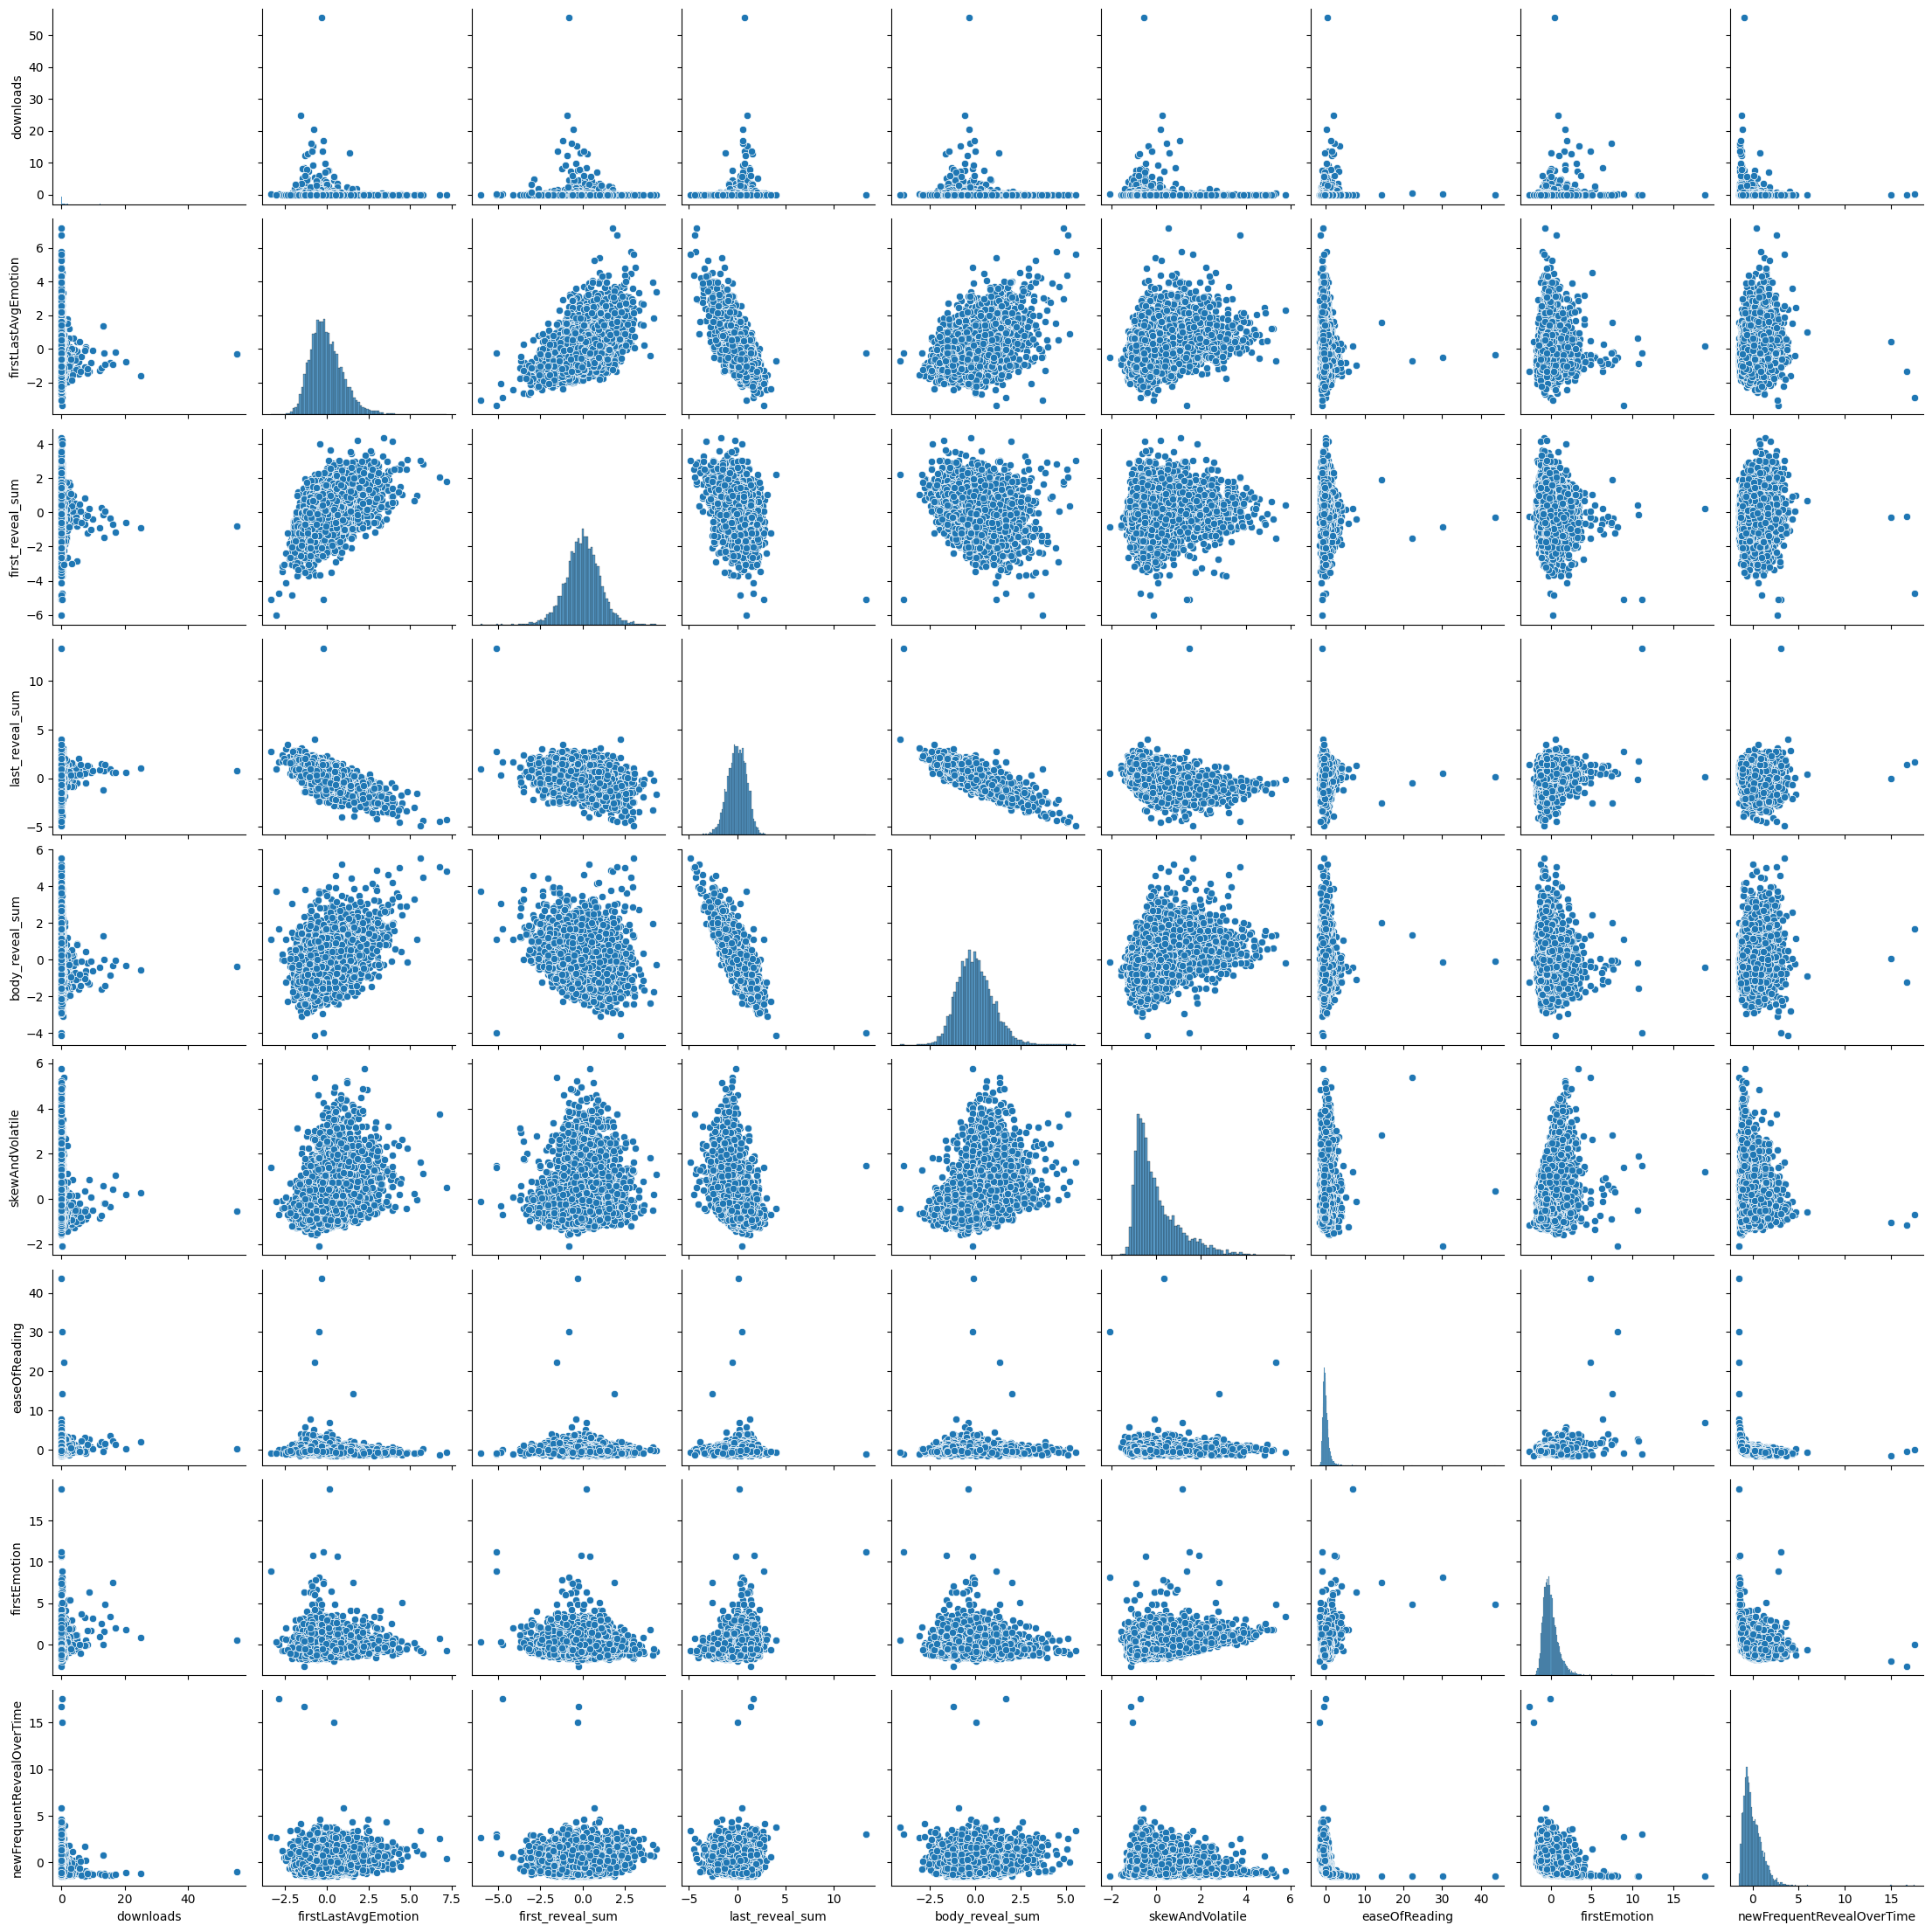

In [59]:
sns.pairplot(data=new)
#plt.savefig("sqrt_plot.pdf")


In [57]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


data[
  [
  
  "downloads",
  "firstLastAvgEmotion",
    "first_reveal_sum",
    "last_reveal_sum",
    "body_reveal_sum",
    "skewAndVolatile",
    #"kurt_structure",
    #"kurt_emotion",
    "easeOfReading",
    "firstEmotion",
    "newFrequentRevealOverTime",
  ]
] = scaler.fit_transform(data[[
  
  "downloads",
  "firstLastAvgEmotion",
    "first_reveal_sum",
    "last_reveal_sum",
    "body_reveal_sum",
    "skewAndVolatile",
    #"kurt_structure",
    #"kurt_emotion",
    "easeOfReading",
    "firstEmotion",
    "newFrequentRevealOverTime",
  ]])
data

,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type,filename,...,author_len,multiauth,max_min_sentiment,newFrequentRevealOverTime,slope_emotion,firstLastAvgEmotion,skewAndVolatile,kurt_emotion,easeOfReading,firstEmotion
1,PG102,The Tragedy of Pudd'nhead Wilson,"Twain, Mark",1835.0,1910.0,['en'],1.044375,"{'Trials (Murder) -- Fiction', 'Impostors and ...",Text,PG102,...,3.000000,1,0.000405,3.995485,0.111448,-0.487632,-0.517529,484.738804,-0.748914,-0.250361
2,PG105,Persuasion,"Austen, Jane",1775.0,1817.0,['en'],4.722192,"{'Regency fiction', 'Ship captains -- Fiction'...",Text,PG105,...,2.500000,1,0.000324,-0.505333,0.009087,0.405160,-0.271130,674.816020,-0.148201,-0.095417
3,PG106,Jungle Tales of Tarzan,"Burroughs, Edgar Rice",1875.0,1950.0,['en'],0.253146,"{'Tarzan (Fictitious character) -- Fiction', '...",Text,PG106,...,2.666667,1,0.000284,-0.285809,-0.018441,-1.228725,-0.364909,1035.575060,-0.290865,-0.556840
4,PG107,Far from the Madding Crowd,"Hardy, Thomas",1840.0,1928.0,['en'],0.830813,"{'Love stories', 'Wessex (England) -- Fiction'...",Text,PG107,...,2.076923,1,0.000393,-0.941388,0.012229,-0.765321,-0.726038,-7.495825,0.383330,0.842773
5,PG108,The Return of Sherlock Holmes,"Doyle, Arthur Conan",1859.0,1930.0,['en'],2.159449,"{'Detective and mystery stories, English', 'Ho...",Text,PG108,...,9.157895,1,0.000251,-0.950027,0.043225,-0.718530,-0.926056,248.398984,0.553419,-0.399974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8544,PG56752,Double Play: A Story of School and Baseball,"Barbour, Ralph Henry",1870.0,1944.0,['en'],-0.109209,"{'Baseball -- Juvenile fiction', 'Baseball sto...",Text,PG56752,...,6.750000,1,0.000324,0.752637,0.052808,-0.242504,-0.561550,833.820676,-0.376917,-0.506679
8545,PG56870,Tales from Gorky,"Gorky, Maksim",1868.0,1936.0,['en'],-0.053193,"{'Short stories, Russian -- Translations into ...",Text,PG56870,...,1.384615,1,0.000349,0.860499,0.009055,-1.319895,-0.015329,1583.178976,-0.470761,-0.504151
8546,PG57137,"Barry Wynn: Or, The Adventures of a Page Boy i...","Barton, George",1866.0,1940.0,['en'],-0.025185,{'Capitol pages -- Fiction'},Text,PG57137,...,0.357143,0,0.000300,1.376819,0.090497,0.539503,-0.526242,499.379683,-0.608529,-0.674463
8547,PG57166,Just a Girl,"Garvice, Charles",1850.0,1920.0,['en'],-0.033938,{'English fiction -- 19th century'},Text,PG57166,...,2.812500,1,0.000452,-1.116471,-0.050346,-1.013537,-0.278640,142.039026,-0.023263,2.014556


In [112]:


pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# Add constant to X for intercept
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X)
results = model.fit()

# Print summary of regression results
print(results.summary())




vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)




# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform LASSO with cross-validation
lasso = LassoCV(cv=5).fit(X_scaled, y)

# Extract the coefficients
lasso_coef = lasso.coef_

# Create a DataFrame to see which variables are selected
lasso_results = pd.DataFrame({'Variable': X.columns, 'Coefficient': lasso_coef})
#print(lasso_results[lasso_results['Coefficient'] != 0])

                            OLS Regression Results                            
Dep. Variable:              downloads   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     26.99
Date:                Sat, 29 Jun 2024   Prob (F-statistic):           1.27e-60
Time:                        18:45:24   Log-Likelihood:                -55250.
No. Observations:                7134   AIC:                         1.105e+05
Df Residuals:                    7121   BIC:                         1.106e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

/Users/bhargavcn/Projects/fiction-info/venv/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
